In [1]:
# 說明：設置環境、import 套件
import pandas as pd
import numpy as np
import pprint 
import matplotlib.pyplot as plt
from matplotlib import pylab
%pylab inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (20, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# color sets
cPurple = '#5628B4'
cLightPurple = '#9590D0'
cRed = '#D2553E'
cGreen = '#98B855'

In [3]:
import matplotlib.font_manager as fm 
myfont = fm.FontProperties( fname="/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc")   

In [4]:
# Global variables
CostRate = 3 # 一度電多少錢（估算，實際還要再確認）

### 原始資料說明 - 1
- 區間：去年 09/01 - 11/10，七一天
    - 這份資料區間以方便分析為主，所以 71 天只是 1.0 版本，之後會擴張到整學期
- 間隔：一小時一筆
- 地點：所有的學生宿舍，以下我是針對十二舍做
- 一個地點的筆數：每棟大樓共 71(day) * 24(hr) = 1704 筆
- 總筆數 = 1704 * 17 = 28968 筆

In [5]:
df = pd.read_csv('data/data0226_0901_1110_hr_dorm.csv') # 讀檔案
df.columns # 有哪些欄位

Index(['DateTime', 'Area', 'Building', 'Loop', 'Type', 'Usage'], dtype='object')

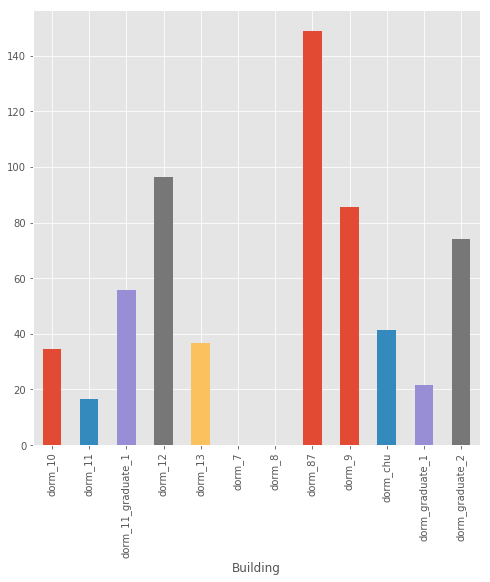

In [47]:
pylab.rcParams['figure.figsize'] = (8, 8)


df.groupby('Building').Usage.mean().plot.bar()

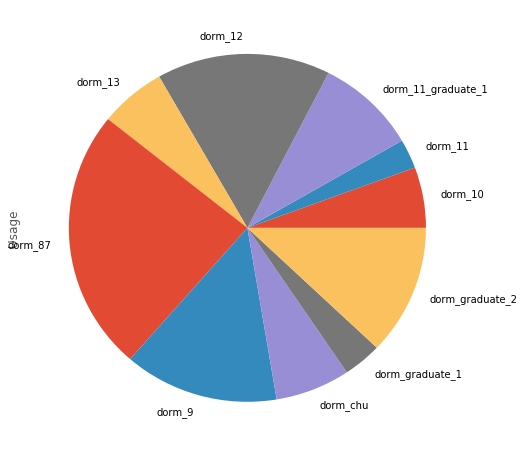

In [48]:
pylab.rcParams['figure.figsize'] = (8, 8)
df.groupby('Building').Usage.mean().plot.pie()
pylab.rcParams['figure.figsize'] = (20, 8)

### 原始資料說明 - 2
- index: ['﻿時  間', '區 域', '館 舍 別', '迴 路 別', '用電別', '用電量(單位:度)']

### 人工資料前處理：改變欄位名稱
#### 改變的原因
- 原始的資料有空白在字串裡，會造成一些麻煩
- 英文的名稱，可以在Pandas寫Code時較為方便(才能用 df.Usage的指令)

#### 改了什麼
- 我用Number(Excel)的尋找取代功能，把資料轉成英文，以下括弧表示原始資料的命名
    - 區域：southArea(南區), northArea(北區)
    - 迴 路 別: mainLoop（主迴路）, familyMart（1F便利超商）, club（社團）, socialHall（閱覽交誼廳）, studentHall（學生交誼廳）, streetLight(環校路燈),
    - 館舍： dorm_13（學生十三舍）,(7,8,9,10,11,12 以此類推), dorm_graduate_2（研二）, dorm_87（學生七舍＿八舍）, dorm_13_graduate_1(11與研一), dorm_chu（竹軒）
    - 用電別：rent（外租）, dorm（宿舍）, admin(行政)

Adrain建議: 這部分應該透過 Pandas 寫好，才可以省下每筆資料要手動處理的時間

---
# 以下開始，正式透過 Pandas 來處理 / 分析資料

### 新增欄位：由DateTime的資訊，新增日期、時間、Weekday、Week
- def generate_date_time_columns(df)
    - 放進一個含有 DateTime 欄位的 df, 並寫且回傳新增 Date, Time, Weekday, Week的欄位
- Date, Time: 為了之後更方便用日期、時間去存取，分群比較。
- Weekday: 為了去了解週一到週日的用電變化
- Weekday: 為了後續容易掌握每週變化

In [7]:
def generate_date_time_columns(df):
    if('DateTime' in df.columns):
            df['Date'] = df.DateTime.str[:10]
            df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
            df['Weekday'] = df['Date'].dt.dayofweek + 1
            df['Time'] = df.DateTime.str[11:]
            df['Week'] = df['Date'].dt.week
            print('Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame')
    else:
        print('DataTime not in column. Please rename columns name.')
    return df

In [8]:
df = generate_date_time_columns(df)

Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame


In [9]:
# cost_rate：一度電大概多少錢
def generate_cost_columns(df, cost_rate):
    df['Cost'] = df.Usage * cost_rate
    print('Column "Cost" had been generated!')
    return df

In [10]:
df = generate_cost_columns(df, CostRate)

Column "Cost" had been generated!


### 將資料切成三份
原本的資料集包含不同種類（宿舍、外租、行政）的欄位，而因為我們要專注分析宿舍用電，所以將資料切成三份

In [11]:
df_dorm = df[df.Type == 'dorm'] #以下專注在 df_dorm的分析
df_rent = df[df.Type == 'rent']
df_admin = df[df.Type == 'admin']

### 處理 df_dorm 的離群值

In [12]:
# 找離群值：找出最大的五個值，用肉眼可以看出離群值
df_dorm.sort_values('Usage')[-5:]

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost
19247,2017/09/21 23:00,southArea,dorm_87,mainLoop,dorm,346.00,2017-09-21,4,23:00,38,1038.00
19367,2017/09/26 23:00,southArea,dorm_87,mainLoop,dorm,348.00,2017-09-26,2,23:00,39,1044.00
19343,2017/09/25 23:00,southArea,dorm_87,mainLoop,dorm,350.00,2017-09-25,1,23:00,39,1050.00
1955,2017/09/11 11:00,southArea,dorm_13,club,dorm,1039.70,2017-09-11,1,11:00,37,3119.10
6277,2017/10/19 13:00,northArea,dorm_10,studentHall,dorm,55471.62,2017-10-19,4,13:00,42,166414.86


In [13]:
# 手動改離群值，如果離群值太多得用更完整的方式
df.loc[6277,'Usage']  = 0.87 #  0.87 約是前後的值得大小
df.loc[6277,'Cost']  = df.loc[6277,'Usage'] * CostRate # 記得連Cost 一起改過來
df.iloc[6277]

DateTime       2017/10/19 13:00
Area                  northArea
Building                dorm_10
Loop                studentHall
Type                       dorm
Usage                      0.87
Date        2017-10-19 00:00:00
Weekday                       4
Time                      13:00
Week                         42
Cost                       2.61
Name: 6277, dtype: object

In [14]:
# 這天的離群值，猜測來自之前欄位的位移
# 驗證：看之前欄位的值，有2145筆是零
print(df.iloc[4207:6277].Usage.value_counts())

0.00    2045
0.25       6
0.26       4
0.24       3
0.19       3
0.20       2
0.21       2
0.22       2
3.24       1
5.41       1
0.01       1
Name: Usage, dtype: int64


### 了解每個欄位有多少種不同的值
因為Pandas似乎只有內建針對特定欄位的 unique ，而沒有把所有欄位的Unique 一次列出來的功能，
就自己寫一個

In [15]:
# 用自訂函式去理解DF中每個欄位有哪幾種類別的值
def understand(df):
    for col_name in df.columns:
        print ('>>> "{}" has {} unique values:'.format(col_name, len(df[col_name].unique())))
        if(len(df[col_name].unique())<50):
            pprint.pprint(df[col_name].unique())
        else:
            pprint.pprint('The value is more than 50 so wont be list here :P')
        print('\n')
understand(df_dorm)

>>> "DateTime" has 1704 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 2 unique values:
array(['southArea', 'northArea'], dtype=object)


>>> "Building" has 12 unique values:
array(['dorm_13', 'dorm_10', 'dorm_chu', 'dorm_9', 'dorm_11_graduate_1',
       'dorm_11', 'dorm_graduate_1', 'dorm_87', 'dorm_7', 'dorm_8',
       'dorm_12', 'dorm_graduate_2'], dtype=object)


>>> "Loop" has 4 unique values:
array(['club', 'socialHall', 'studentHall', 'mainLoop'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 2623 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 71 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([5, 6, 7, 1, 2, 3, 4])


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '

# Part 2 Dorm 12 分析
我們先嘗試建立一個對於交大十二舍(Dorm 12)的分析，接著把這樣的分析方式寫成 general function()，套用到其他宿舍上

In [17]:
df_dorm_12 = df[df.Building == 'dorm_graduate_1'][df.Loop == 'mainLoop']

/Users/ah-bau/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


### 基本資訊

In [18]:
df_dorm_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704 entries, 17040 to 18743
Data columns (total 11 columns):
DateTime    1704 non-null object
Area        1704 non-null object
Building    1704 non-null object
Loop        1704 non-null object
Type        1704 non-null object
Usage       1704 non-null float64
Date        1704 non-null datetime64[ns]
Weekday     1704 non-null int64
Time        1704 non-null object
Week        1704 non-null int64
Cost        1704 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 159.8+ KB


In [19]:
understand(df_dorm_12)

>>> "DateTime" has 1704 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 1 unique values:
array(['northArea'], dtype=object)


>>> "Building" has 1 unique values:
array(['dorm_graduate_1'], dtype=object)


>>> "Loop" has 1 unique values:
array(['mainLoop'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 169 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 71 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([5, 6, 7, 1, 2, 3, 4])


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)


>>> "Week" has 11 unique values:
array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])


>>> 

In [20]:
df_dorm_12.Usage.describe() #統計上了解用電狀況

count    1704.000000
mean       21.423433
std         4.261281
min         8.250000
25%        18.250000
50%        20.500000
75%        23.880000
max        37.750000
Name: Usage, dtype: float64

# 2.1 十二舍繪圖分析
## 了解變化
- 了解各周的變化：
- 了解星期一在每週的變化
- 了解日用電隨小時的變化：平均
    - 每週平均比較
    - 各週星期一比較
- 成長率
    - 每星期一的變化
    - 每小時變化：抓出突然用電

## 異常值
- 最大值
- 最小值

## 多館舍比較
- 日夜用電比
- Box Plot


In [22]:
# 12舍的總電費（假設一度 3 元）
money = df_dorm_12.groupby('Date').sum().reset_index().Cost.sum()
date = df_dorm_12.Date.unique()
print('If one degree electricity costs {} NTD, from {} to {} ({} day), dorm 12 costs {} NTD'.format(CostRate,str(date[-1])[:10],str(date[0])[:10],len(date),money))

If one degree electricity costs 3 NTD, from 2017-11-10 to 2017-09-01 (71 day), dorm 12 costs 109516.59000000001 NTD


### 圖一：每個小時的用電，71天（Line Plot）
#### 觀察
- 週末的時候（藍線最高點），通常用電比較低
- 圖片中間有個低潮，猜測是國慶連假
- 隨著冬天而下降
- 資料波動大

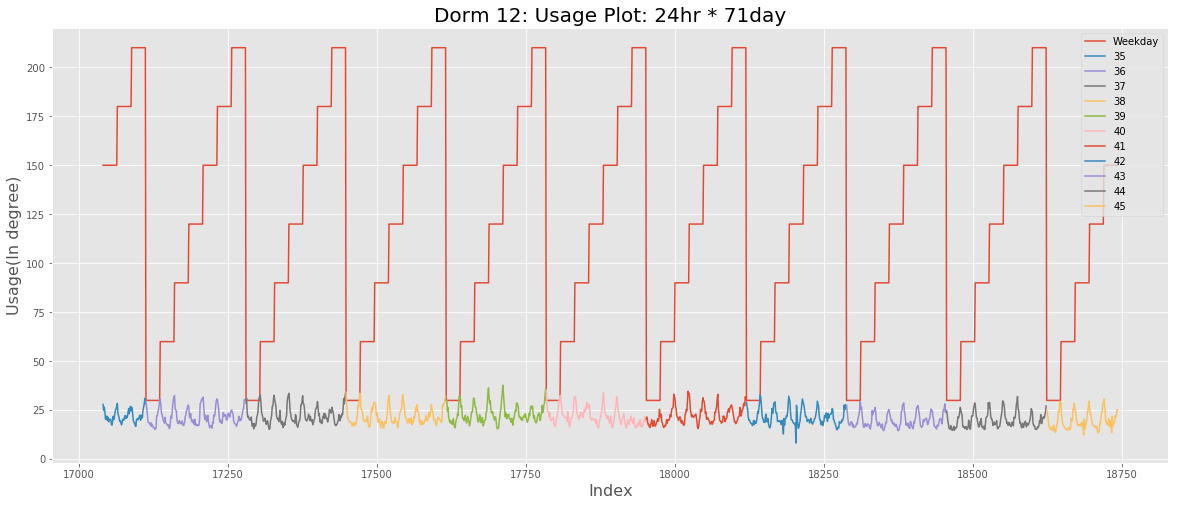

In [23]:
# 71 天每小時的用電資料 (1704個點)

(df_dorm_12.Weekday * 30).plot(legend = True)
# plt.xlabel('index')

df_dorm_12.groupby(['Week']).Usage.plot(legend = True)
#.Usage.plot(legend = True)
plt.title('Dorm 12: Usage Plot: 24hr * 71day', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Index',fontsize = 16)


### 圖二：最高日用電 
討論極端值的成因

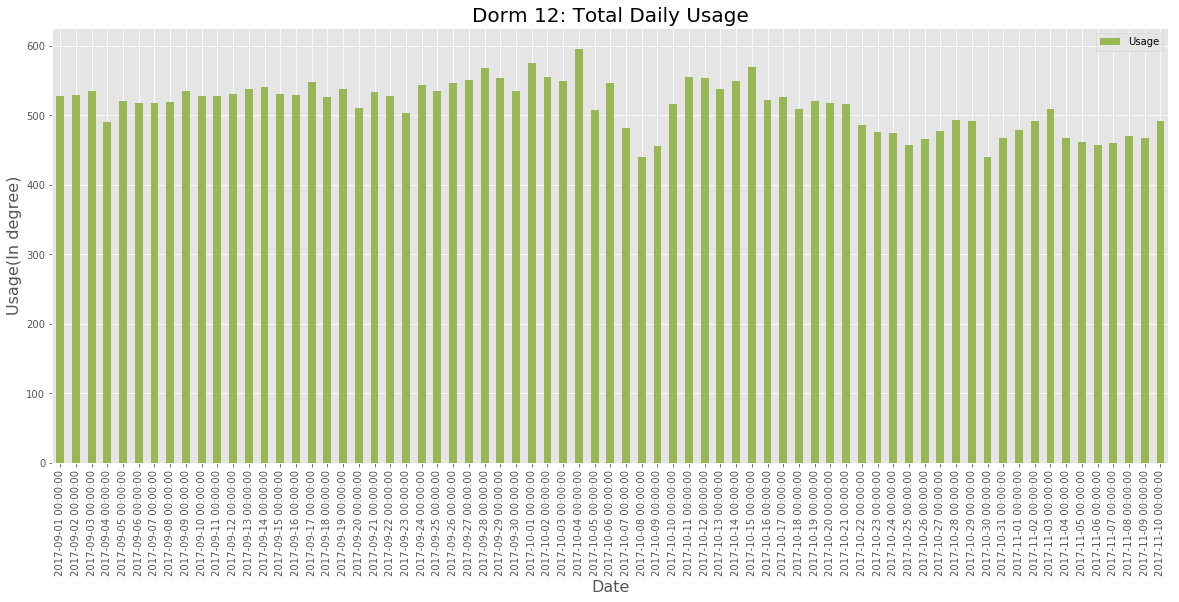

In [24]:
df_dorm_12_dailysum = df_dorm_12.groupby('Date').sum()
df_dorm_12_dailysum.Weekday = df_dorm_12_dailysum.Weekday/24
df_dorm_12_dailysum.Usage.plot.bar(legend = True,color = cGreen)
plt.title('Dorm 12: Total Daily Usage', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

In [25]:
# 最高用電的幾天是...
# 為什麼這幾天會比較高呢？
print('Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailysum.sort_values('Usage')[-10:])
# print('Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10')
# print(df_dorm_12_dailymean_sorted[-10:])

Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10
             Usage  Weekday  Week     Cost
Date                                      
2017-10-03  549.31      2.0   960  1647.93
2017-09-27  550.57      3.0   936  1651.71
2017-09-29  553.69      5.0   936  1661.07
2017-10-12  553.70      4.0   984  1661.10
2017-10-11  554.54      3.0   984  1663.62
2017-10-02  555.17      1.0   960  1665.51
2017-09-28  568.07      4.0   936  1704.21
2017-10-15  568.70      7.0   984  1706.10
2017-10-01  574.43      7.0   936  1723.29
2017-10-04  595.81      3.0   960  1787.43


觀察：其實最高用電的前十個日子，大多發生在九月十月，而且有連續的現象！

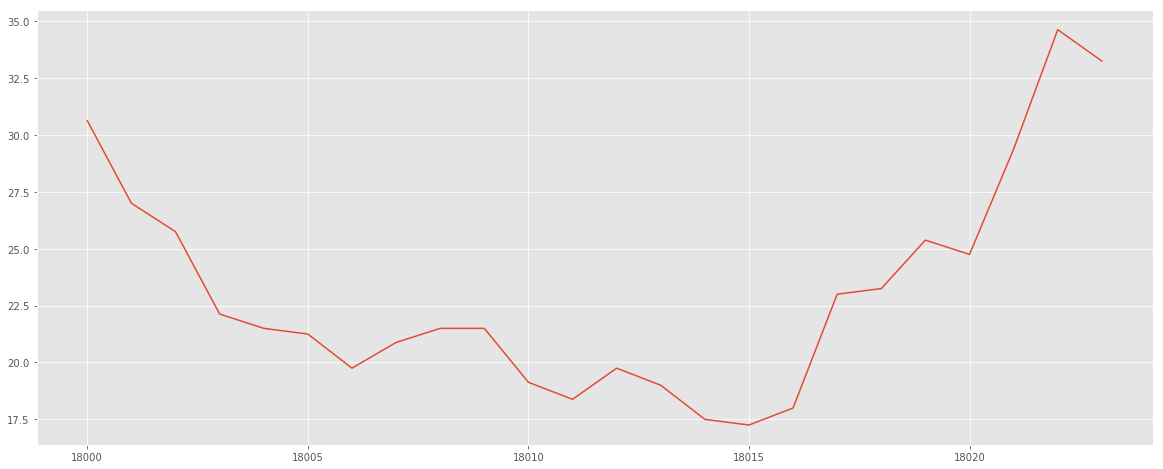

In [26]:
# 10.11 的用電繪圖
df_dorm_12[df_dorm_12.Date == '2017-10-11'].Usage.plot()
# xticks = list(df_dorm_12.Time.unique()) # bug to fix!!
# 不正常的地方：中午高峰

In [27]:
# 哪小時最耗電？
df_dorm_12.sort_values('Usage')[-100:].Time.value_counts()

23:00    35
00:00    27
22:00    26
01:00     5
21:00     4
02:00     2
20:00     1
Name: Time, dtype: int64

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost
17711,2017/09/28 23:00,northArea,dorm_graduate_1,mainLoop,dorm,37.75,2017-09-28,4,23:00,39,113.25


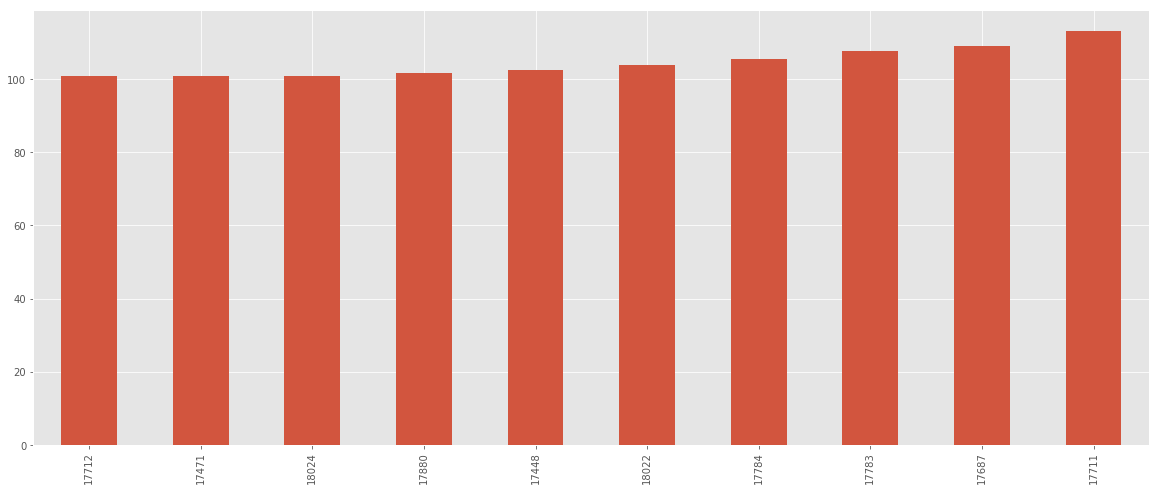

In [28]:
# Top 10 用電
# 看一下特高用電有多誇張，結果其實還好
df_dorm_12.sort_values('Usage')[-10:].Cost.plot.bar(color = cRed)
#發現有一小時真的特耗電

df_dorm_12.sort_values('Usage')[-1:]
# 2017/09/11 22:00 用電是 238.5, (12舍平均用電是96)

2017/9/11 為什麼用那麼多電呢？
我去查了日曆，原來是開學日的十點（一起打電動？煮火鍋？）

In [29]:
# 五十天中，星期幾最耗電？
df_dorm_12.groupby('Date').mean().sort_values('Usage')[-50:].Weekday.value_counts()

5    10
6     8
4     7
3     7
2     7
7     6
1     5
Name: Weekday, dtype: int64

### 圖三：平均用電變化 - 依Weekday看
#### 觀察
- 週六大家回家，平均用電最低
- 週日回宿舍，用電比週六週五高

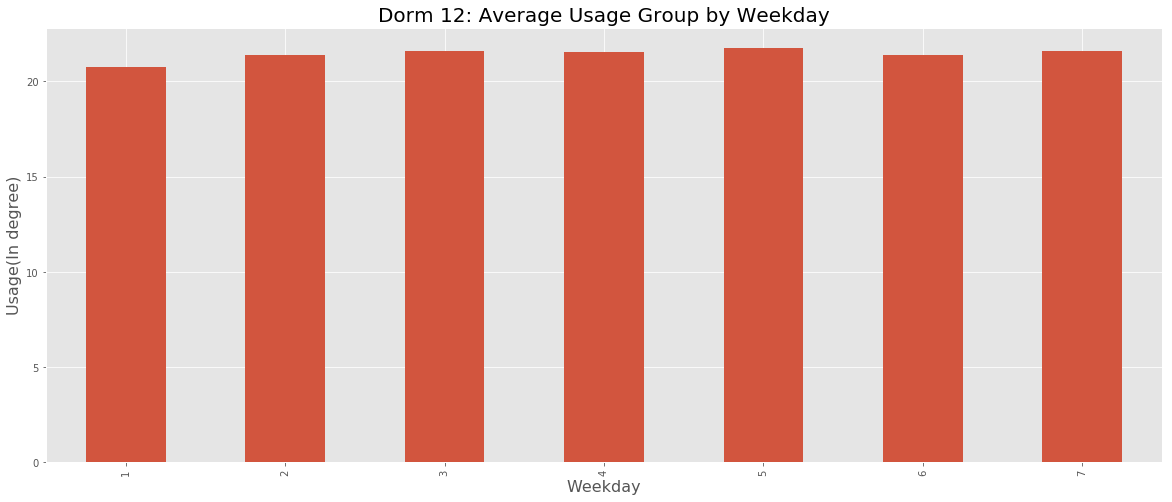

In [30]:
df_dorm_12_byWeekday = df_dorm_12.groupby('Weekday').mean()
df_dorm_12_byWeekday.Usage.plot.bar(legend = False,color = cRed)

plt.title('Dorm 12: Average Usage Group by Weekday', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Weekday',fontsize = 16)

### 圖三：各週用電變化 - 依Weekday看

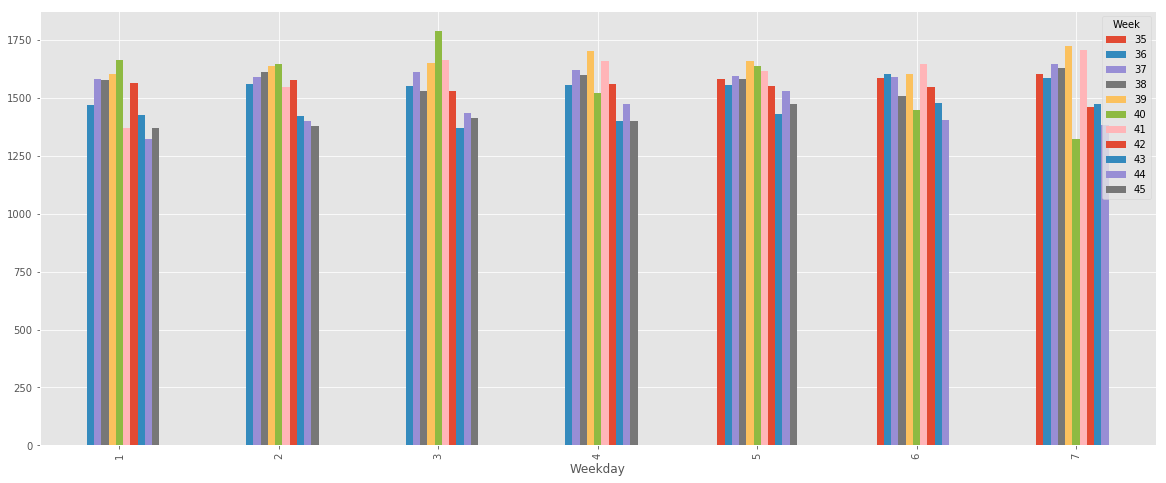

In [31]:
df_dorm_12.groupby(['Weekday','Week']).Cost.sum().unstack().plot.bar(legend = True)
#.Usage.plot(legend = True)
# 跟上一張圖的差別：可以看各周的變化

In [32]:
# 注意：取資料時，週五多一天
df_dorm_12.Weekday.value_counts()

5    264
7    240
6    240
4    240
3    240
2    240
1    240
Name: Weekday, dtype: int64

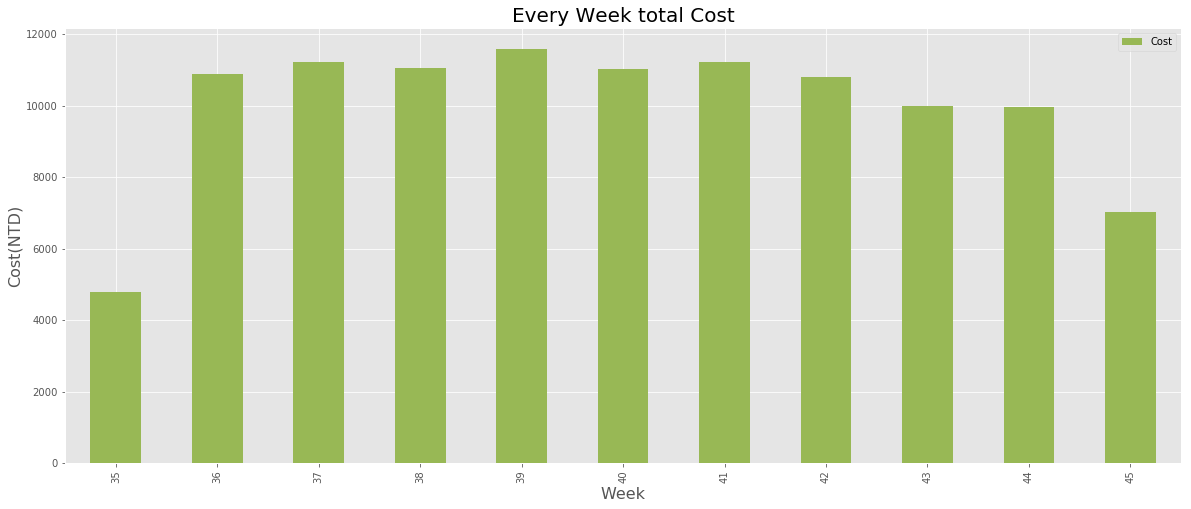

In [33]:
# df_dorm_12.groupby('Date').sum().Usage.plot.bar()
df_dorm_12.groupby('Week').sum().Cost.plot.bar(legend = True, color = cGreen)
plt.title('Every Week total Cost', fontsize = 20)
pylab.ylabel('Cost(NTD)',fontsize = 16)
pylab.xlabel('Week',fontsize = 16)

### 圖四：平均用電變化 - 依小時看

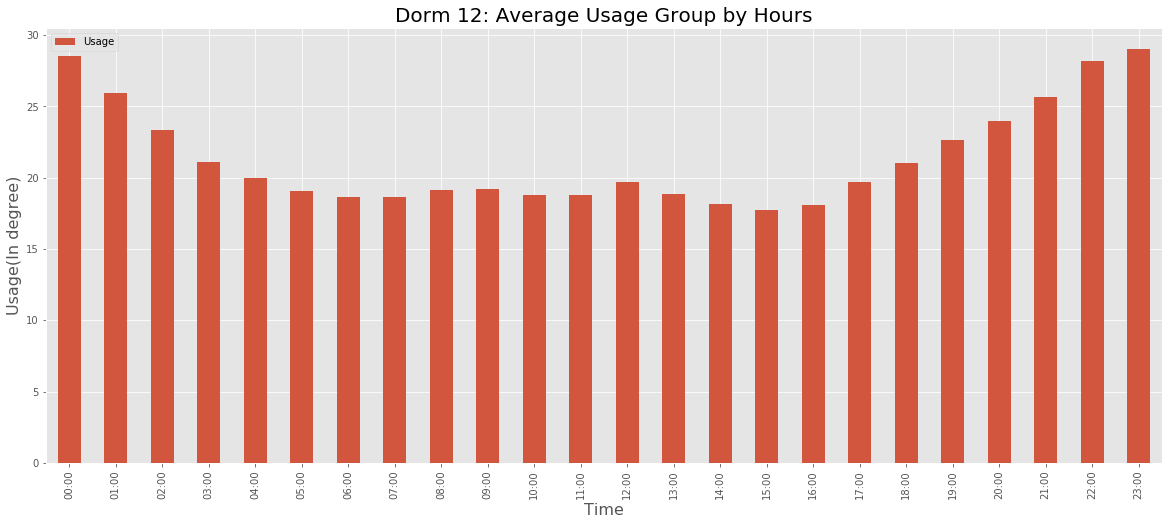

In [34]:
df_dorm_12.groupby('Time').Usage.mean().plot.bar(legend = True, color = cRed)
plt.title('Dorm 12: Average Usage Group by Hours', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Time',fontsize = 16)

### 觀察
- 這張是我覺得最有趣的，想法：可以拿去跟男生十舍比，看十二舍的人是不是比較早睡（省電）
- 最高用電落在晚上十一點到十二點。十二點會關燈。
- 關燈之後的下跌應該就是人為用電的減少（去睡覺了），人為用電除了桌電、吹風機以外，不知道洗澡熱水器有沒有被算在內？
- 早上七點起床有個Peak，可能是洗澡或開燈
- 中午十二點也有Peak，可能是回宿舍吃中飯
- 晚上六點開燈，所以用電升幅大

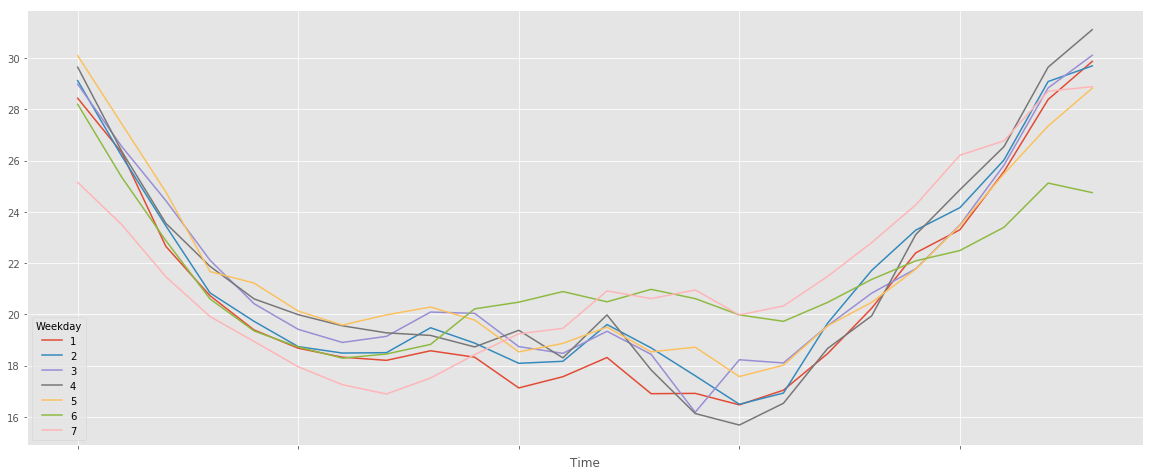

In [35]:
df_dorm_12.groupby(['Time','Weekday']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

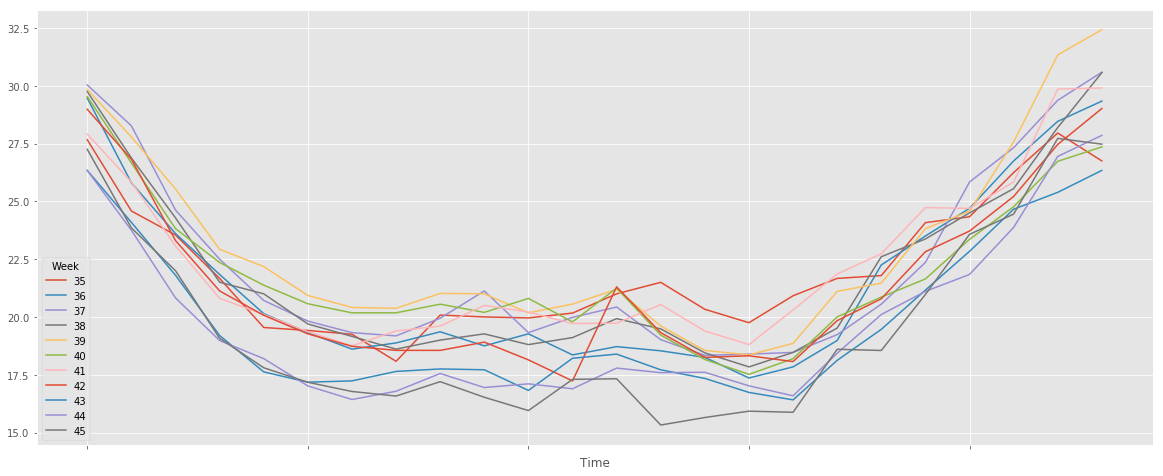

In [36]:
df_dorm_12.groupby(['Time','Week']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

### 圖七：每周在某一個時刻的用電變化 

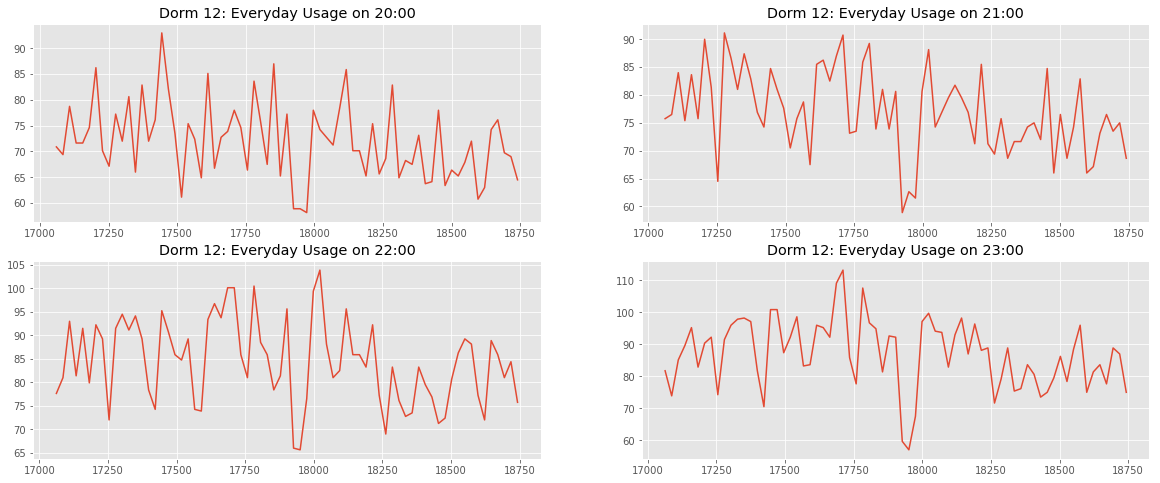

In [37]:
# 觀看某一個小時的用電量，在每天的變化

# df_dorm_12[df_dorm_12.Time == '23:00'].info()
fig, axes = plt.subplots(nrows=2, ncols=2)
df_dorm_12[df_dorm_12.Time == '20:00'].Cost.plot(ax=axes[0,0],title = 'Dorm 12: Everyday Usage on 20:00')
df_dorm_12[df_dorm_12.Time == '21:00'].Cost.plot(ax=axes[0,1],title = 'Dorm 12: Everyday Usage on 21:00')
df_dorm_12[df_dorm_12.Time == '22:00'].Cost.plot(ax=axes[1,0],title = 'Dorm 12: Everyday Usage on 22:00')
df_dorm_12[df_dorm_12.Time == '23:00'].Cost.plot(ax=axes[1,1],title = 'Dorm 12: Everyday Usage on 23:00')

## 成長率

In [38]:
# 使用 .pct_change()
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change().head()

Week  Weekday
35    5               NaN
      6          0.001895
      7          0.010647
36    1         -0.083435
      2          0.061204
Name: Cost, dtype: float64

/Users/ah-bau/anaconda/lib/python3.5/site-packages/matplotlib/transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


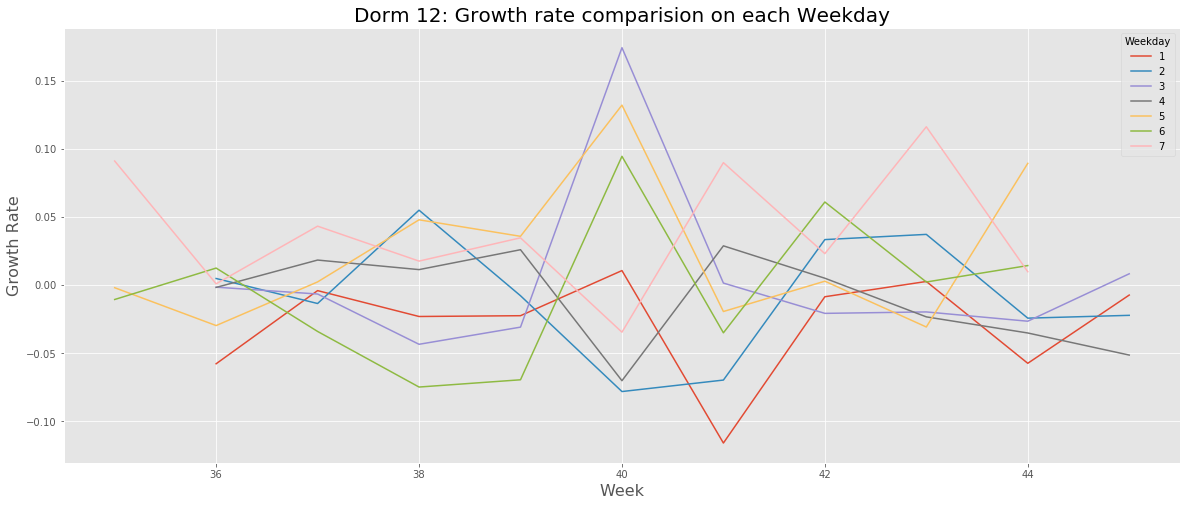

In [39]:
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change(-1).unstack().plot()
plt.title('Dorm 12: Growth rate comparision on each Weekday', fontsize = 20)
pylab.ylabel('Growth Rate',fontsize = 16)
pylab.xlabel('Week',fontsize = 16) 

In [40]:
#探討peak的成因
df_dorm_12.groupby(['Week','Weekday']).mean().Cost.pct_change(-1).sort_values()[-10:]


Week  Weekday
38    2          0.054963
42    6          0.060971
44    5          0.089317
41    7          0.089839
35    7          0.091030
40    6          0.094474
43    7          0.116134
40    5          0.132020
      3          0.174149
45    5               NaN
Name: Cost, dtype: float64

                   Usage  Week       Cost
Time  Weekday                            
00:00 1        28.441000  40.5  85.323000
      2        29.126000  40.5  87.378000
      3        28.990000  40.5  86.970000
      4        29.653000  40.5  88.959000
      5        30.104545  40.0  90.313636
      6        28.203000  39.5  84.609000
      7        25.153000  39.5  75.459000
01:00 1        26.316000  40.5  78.948000
      2        26.176000  40.5  78.528000
      3        26.552000  40.5  79.656000
                  Usage      Week      Cost
Time  Weekday                              
00:00 1       -0.023519  0.000000 -0.023519
      2        0.004691  0.000000  0.004691
      3       -0.022359  0.000000 -0.022359
      4       -0.014999  0.012500 -0.014999
      5        0.067424  0.012658  0.067424
      6        0.121258  0.000000  0.121258
      7       -0.044194 -0.024691 -0.044194
01:00 1        0.005348  0.000000  0.005348
      2       -0.014161  0.000000 -0.014161
      3     

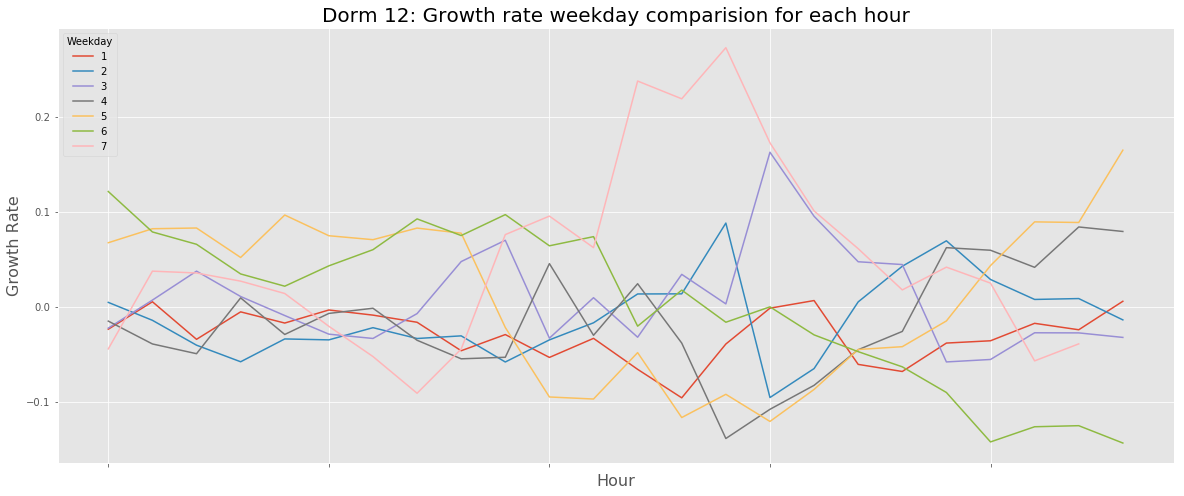

In [41]:
print(df_dorm_12.groupby(['Time','Weekday']).mean()[:10])
print(df_dorm_12.groupby(['Time','Weekday']).mean().pct_change(-1)[:10])
df_dorm_12.groupby(['Time','Weekday']).mean().Cost.pct_change(-1).unstack().plot()
plt.title('Dorm 12: Growth rate weekday comparision for each hour', fontsize = 20)
pylab.ylabel('Growth Rate',fontsize = 16)
pylab.xlabel('Hour',fontsize = 16) 

## 白天 / 晚上用電比率

In [42]:
# df_dorm_12.groupby(['Time','Weekday])
# df_dorm_12_night = df_dorm_12[((df_dorm_12.Time == '03:00') or (df_dorm_12.Time == '04:00') or (df_dorm_12.Time == '05:00'))]
df_dorm_12_night = df_dorm_12.loc[df_dorm_12['Time'].isin(['03:00', '04:00', '05:00', '06:00'])]
df_dorm_12_day = df_dorm_12.loc[df_dorm_12['Time'].isin(['07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00'])]
df_dorm_12_night = df_dorm_12_night.groupby('Date').mean()# 夜晚用電
df_dorm_12_day = df_dorm_12_day.groupby('Date').mean()
(df_dorm_12_day/df_dorm_12_night).head()

,Usage,Weekday,Week,Cost
Date,,,,
2017-09-01,0.907327,1.0,1.0,0.907327
2017-09-02,1.062582,1.0,1.0,1.062582
2017-09-03,1.118916,1.0,1.0,1.118916
2017-09-04,0.903819,1.0,1.0,0.903819
2017-09-05,0.871443,1.0,1.0,0.871443


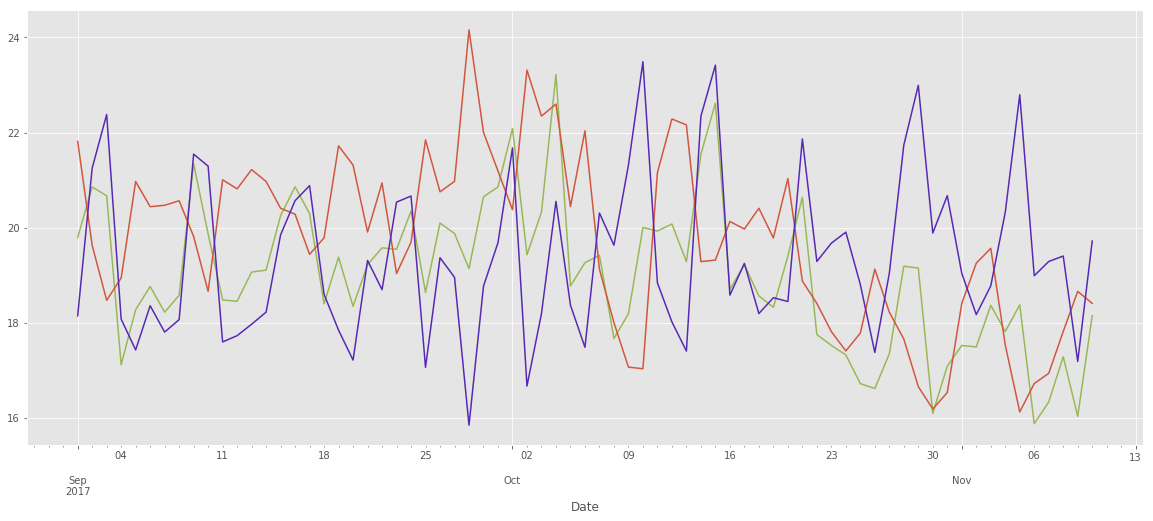

In [44]:
df_dorm_12_day.Usage.plot(color = cGreen)
df_dorm_12_night.Usage.plot(color = cRed)
((df_dorm_12_day/df_dorm_12_night).Usage*20).plot(color = cPurple) 
# bug ： 如何把兩個不同scale的圖畫再一起
# bug ： 如何畫線